<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**
-   DateCrawled — дата скачивания анкеты из базы
-   VehicleType — тип автомобильного кузова
-   RegistrationYear — год регистрации автомобиля
-   Gearbox — тип коробки передач
-   Power — мощность (л. с.)
-    Model — модель автомобиля
-   Kilometer — пробег (км)
-   RegistrationMonth — месяц регистрации автомобиля
-   FuelType — тип топлива
-   Brand — марка автомобиля
-   NotRepaired — была машина в ремонте или нет
-   DateCreated — дата создания анкеты
-   NumberOfPictures — количество фотографий автомобиля
-   PostalCode — почтовый индекс владельца анкеты (пользователя)
-   LastSeen — дата последней активности пользователя

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [2]:
RAND = 42

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Переведем даты в формат datetime:

In [5]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d')

#последнее время вхождения, после которого учет скорее всего не велся:
last_time = pd.to_datetime(df['LastSeen'].max(), format='%Y-%m-%d')
last_time

Timestamp('2016-04-07 14:58:51')

Преобразуем даты в соответствии с тем, сколько дней прошло от последнего таймстемпа:

In [6]:
df['DateCrawled'] = (last_time - df['DateCrawled']).dt.days
df['DateCreated'] = (last_time - df['DateCreated']).dt.days
df['LastSeen'] = (last_time - df['LastSeen']).dt.days

Рассмотрим пропуски:

In [7]:
def NaN_percentage(series):
       return str(
           round(reduce(lambda x, y: x + y, series) / len(series) * 100, 2)
       ) + '%'

df.isna().agg(['sum', NaN_percentage]).T[df.isna().sum() > 0].T

,VehicleType,Gearbox,Model,FuelType,NotRepaired
sum,37490,19833,19705,32895,71154
NaN_percentage,10.58%,5.6%,5.56%,9.28%,20.08%


Так как пропуски находятся лишь в категориальных столбцах, заполним их техническим значением `unknown`:

In [8]:
nan_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
df[nan_cols] = df[nan_cols].fillna('unknown')
df[nan_cols].sample(10, random_state=RAND)

,VehicleType,Gearbox,Model,FuelType,NotRepaired
294049,wagon,manual,leon,petrol,no
76415,wagon,manual,a3,gasoline,unknown
212563,wagon,manual,passat,gasoline,no
109307,small,manual,corsa,petrol,yes
248545,unknown,manual,a_klasse,petrol,unknown
318907,convertible,unknown,3_reihe,petrol,no
227367,sedan,auto,other,petrol,no
47677,unknown,manual,astra,petrol,no
337147,small,manual,500,petrol,no
164456,convertible,unknown,unknown,unknown,no


In [9]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.000000
mean,16.544012,4416.656776,2004.234448,110.094337,128211.172535,5.714645,17.199910,0.0,50508.689087,8.153927
std,9.103082,4514.158514,90.227958,189.850405,37905.341530,3.726421,9.386211,0.0,25783.096248,9.176182
min,0.000000,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,0.0,1067.000000,0.000000
25%,9.000000,1050.000000,1999.000000,69.000000,125000.000000,3.000000,9.000000,0.0,30165.000000,1.000000
50%,16.000000,2700.000000,2003.000000,105.000000,150000.000000,6.000000,17.000000,0.0,49413.000000,3.000000
75%,25.000000,6400.000000,2008.000000,143.000000,150000.000000,9.000000,25.000000,0.0,71083.000000,15.000000
max,33.000000,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,759.000000,0.0,99998.000000,33.000000


Столбец `NumberOfPictures` состоит из одних нулей, можно от него избавиться:

In [10]:
df = df.drop('NumberOfPictures', axis=1)

In [11]:
df.describe(exclude=np.number)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,354369,354369,354369,354369,354369,354369
unique,9,3,251,8,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


Помимо численных данных имеются категориальные, далеко не все модели могут их обработать.

In [12]:
#имена категориальных столбцов и численных
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()

In [13]:
df_old = df.copy()

Наши категориальные признаки не являются порядковыми, поэтому воспользуемся **прямым кодированием**:

In [14]:
# OHE для категориальных признаков
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.sample(10, random_state=RAND)

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,LastSeen,VehicleType_convertible,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
294049,17,19999,2014,122,30000,3,18,22089,11,0,...,0,0,0,0,0,0,0,0,0,0
76415,13,14250,2011,140,70000,6,13,45770,9,0,...,0,0,0,0,0,0,0,0,1,0
212563,29,2850,2001,131,150000,9,29,38259,26,0,...,0,0,0,0,0,0,1,0,0,0
109307,8,50,1996,60,150000,8,8,7957,4,0,...,0,0,0,0,0,0,0,0,0,1
248545,9,500,2016,82,150000,2,10,49356,7,0,...,0,0,0,0,0,0,0,0,1,0
318907,7,3000,2005,0,150000,0,7,53340,1,1,...,0,0,0,0,0,0,0,0,0,0
227367,18,1099,1983,122,150000,3,19,49779,0,0,...,0,0,0,0,0,0,0,0,0,0
47677,28,850,2016,55,150000,12,28,14656,28,0,...,0,0,0,0,0,0,0,0,0,0
337147,17,7999,2011,99,90000,5,18,71272,0,0,...,0,0,0,0,0,0,0,0,0,0
164456,18,5900,1977,0,100000,7,18,32339,1,1,...,0,1,0,0,0,0,0,0,0,0


Разделим данные на обучающие и проверочные:

In [15]:
def train_valid_test(df):
    target = df['Price']
    features = df.drop('Price', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=RAND)
    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=RAND)
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [16]:
features_train, features_valid, features_test, target_train, target_valid, target_test = train_valid_test(df)
print(features_train.shape, features_valid.shape, features_test.shape)

(212621, 316) (70874, 316) (70874, 316)


Отмасштабируем численные признаки:

In [17]:
#названия численных колонок в фичах:
features_num_cols = [col for col in num_cols if col != 'Price'] 

In [18]:
#отключаем предупреждение
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[features_num_cols])
features_train[features_num_cols] = scaler.transform(features_train[features_num_cols])
features_valid[features_num_cols] = scaler.transform(features_valid[features_num_cols])
features_test[features_num_cols] = scaler.transform(features_test[features_num_cols])

### Вывод

Все пропуски заполнены, категориальные признаки преобразованы, численные отмасштабированы.

In [19]:
df_old.describe(exclude=np.number)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,354369,354369,354369,354369,354369,354369
unique,9,3,251,8,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


In [20]:
top_models = df_old.value_counts('Model')[:10].index.tolist()
top_brands = df_old.value_counts('Brand')[:10].index.tolist()

In [21]:
df_lin = df_old.copy()
df_lin['Model'] = df_lin['Model'].where(df_lin['Model'].isin(top_models), other='other')
df_lin['Brand'] = df_lin['Brand'].where(df_lin['Brand'].isin(top_brands), other='other')
display(df_lin.value_counts('Model'), df_lin.value_counts('Brand'))

Model
other       220868
golf         29232
3er          19761
unknown      19705
polo         13066
corsa        12570
astra        10809
passat       10146
a4            9900
c_klasse      8312
dtype: int64

Brand
volkswagen       77013
other            68355
opel             39931
bmw              36914
mercedes_benz    32046
audi             29456
ford             25179
renault          17927
peugeot          10998
fiat              9643
seat              6907
dtype: int64

OHE:

In [22]:
# OHE для категориальных признаков
df_lin = pd.get_dummies(df_lin, columns=cat_cols, drop_first=True)
df_lin.sample(10, random_state=RAND)

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,LastSeen,VehicleType_convertible,...,Brand_ford,Brand_mercedes_benz,Brand_opel,Brand_other,Brand_peugeot,Brand_renault,Brand_seat,Brand_volkswagen,NotRepaired_unknown,NotRepaired_yes
294049,17,19999,2014,122,30000,3,18,22089,11,0,...,0,0,0,0,0,0,1,0,0,0
76415,13,14250,2011,140,70000,6,13,45770,9,0,...,0,0,0,0,0,0,0,0,1,0
212563,29,2850,2001,131,150000,9,29,38259,26,0,...,0,0,0,0,0,0,0,1,0,0
109307,8,50,1996,60,150000,8,8,7957,4,0,...,0,0,1,0,0,0,0,0,0,1
248545,9,500,2016,82,150000,2,10,49356,7,0,...,0,1,0,0,0,0,0,0,1,0
318907,7,3000,2005,0,150000,0,7,53340,1,1,...,0,0,0,0,1,0,0,0,0,0
227367,18,1099,1983,122,150000,3,19,49779,0,0,...,0,1,0,0,0,0,0,0,0,0
47677,28,850,2016,55,150000,12,28,14656,28,0,...,0,0,1,0,0,0,0,0,0,0
337147,17,7999,2011,99,90000,5,18,71272,0,0,...,0,0,0,0,0,0,0,0,0,0
164456,18,5900,1977,0,100000,7,18,32339,1,1,...,0,0,0,1,0,0,0,0,0,0


In [23]:
features_train_lin, features_valid_lin, features_test_lin, target_train_lin, target_valid_lin, target_test_lin = train_valid_test(df_lin)
print(features_train_lin.shape, features_valid_lin.shape, features_test_lin.shape)

(212621, 46) (70874, 46) (70874, 46)


In [24]:
df_wood = df_old.copy()

In [25]:
le = LabelEncoder()
df_wood[cat_cols] = df_wood[cat_cols].apply(lambda col: le.fit_transform(col))
df_wood.sample(10, random_state=RAND)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
294049,17,19999,8,2014,1,122,140,30000,3,6,30,0,18,22089,11
76415,13,14250,8,2011,1,140,28,70000,6,2,1,1,13,45770,9
212563,29,2850,8,2001,1,131,170,150000,9,2,38,0,29,38259,26
109307,8,50,5,1996,1,60,83,150000,8,6,24,2,8,7957,4
248545,9,500,7,2016,1,82,33,150000,2,6,20,1,10,49356,7
318907,7,3000,1,2005,2,0,10,150000,0,6,25,0,7,53340,1
227367,18,1099,4,1983,0,122,166,150000,3,6,20,0,19,49779,0
47677,28,850,7,2016,1,55,42,150000,12,6,24,0,28,14656,28
337147,17,7999,5,2011,1,99,13,90000,5,6,9,0,18,71272,0
164456,18,5900,1,1977,2,0,228,100000,7,7,33,0,18,32339,1


In [26]:
features_train_wood, features_valid_wood, features_test_wood, target_train_wood, target_valid_wood, target_test_wood = train_valid_test(df_wood)
print(features_train_wood.shape, features_valid_wood.shape, features_test_wood.shape)

(212621, 14) (70874, 14) (70874, 14)


## Обучение моделей

**LinearRegression:**

In [27]:
%timeit
model = LinearRegression()
model.fit(pd.concat([features_train_lin, features_valid_lin]), pd.concat([target_train_lin, target_valid_lin]))

'root_mean_squared_error: ' + str(mean_squared_error(target_test_lin, model.predict(features_test_lin), squared=False))

'root_mean_squared_error: 3345.229328516889'

**DecisionTreeRegressor:**

C OneHotEncoder:

In [28]:
%%time
best_score = 100000000
best_depth = 0
for depth in range(10, 20, 1):
    model = DecisionTreeRegressor(
        max_depth=depth,
        random_state=RAND
    )
    model.fit(features_train, target_train)
    if mean_squared_error(target_valid, model.predict(features_valid), squared=False) < best_score:
        best_score = mean_squared_error(target_valid, model.predict(features_valid), squared=False) #rmse
        best_depth = depth  
'root_mean_squared_error: ' + str(best_score) + ';    depth:' + str(best_depth)

CPU times: user 1min 8s, sys: 3.21 s, total: 1min 12s
Wall time: 1min 12s


'root_mean_squared_error: 2107.3166320944106;    depth:13'

Test:

In [31]:
%%time
model_dtr = DecisionTreeRegressor(
        max_depth=13,
        random_state=RAND
    )
model_dtr.fit(features_train, target_train)
p_test = model_dtr.predict(features_test)
mean_squared_error(target_test, p_test, squared=False)

CPU times: user 6 s, sys: 295 ms, total: 6.29 s
Wall time: 6.29 s


2091.9078150036585

C LabelEncoder:

In [32]:
%%time
best_score = 100000000
best_depth = 0
for depth in range(10, 20, 1):
    model = DecisionTreeRegressor(
        max_depth=depth,
        random_state=RAND
    )
    model.fit(features_train_wood, target_train_wood)
    if mean_squared_error(target_valid_wood, model.predict(features_valid_wood), squared=False) < best_score:
        best_score = mean_squared_error(target_valid_wood, model.predict(features_valid_wood), squared=False) #rmse
        best_depth = depth  
'root_mean_squared_error: ' + str(best_score) + ';    depth:' + str(best_depth)

CPU times: user 12.7 s, sys: 11 ms, total: 12.7 s
Wall time: 12.7 s


'root_mean_squared_error: 2100.1460661210094;    depth:12'

In [37]:
%%time
model_dtr = DecisionTreeRegressor(
        max_depth=12,
        random_state=RAND
    )
model_dtr.fit(features_train_wood, target_train_wood)
p_test = model_dtr.predict(features_test_wood)
mean_squared_error(target_test_wood, p_test, squared=False)

CPU times: user 1.1 s, sys: 7.69 ms, total: 1.11 s
Wall time: 1.11 s


2125.037179367271

C LabelEncoder метрика чуть хуже на тестовых данных, чем с OHE.

**RandomForestRegressor:**

In [38]:
%%time
best_score = 100000000
best_depth = 0
for depth in range(8, 13, 1):
    model = RandomForestRegressor(
        max_depth=depth,
        n_estimators=10,
        random_state=RAND
    )
    model.fit(features_train, target_train)
    if mean_squared_error(target_valid, model.predict(features_valid), squared=False) < best_score:
        best_score = mean_squared_error(target_valid, model.predict(features_valid), squared=False) #rmse
        best_depth = depth  
'root_mean_squared_error: ' + str(best_score) + ';    depth:' + str(best_depth)

CPU times: user 2min 50s, sys: 1.82 s, total: 2min 52s
Wall time: 2min 52s


'root_mean_squared_error: 1960.6598193609934;    depth:12'

In [39]:
%%time
best_score = 100000000
best_n_est = 0
for est in range(5, 10, 1):
    model = RandomForestRegressor(
        max_depth=best_depth,
        n_estimators=est,
        random_state=RAND
    )
    model.fit(features_train, target_train)
    pred_valid = model.predict(features_valid)
    if mean_squared_error(target_valid, pred_valid, squared=False) < best_score:
        best_score = mean_squared_error(target_valid, pred_valid, squared=False)
        best_n_est = est
'root_mean_squared_error: ' + str(best_score) + ';    estimators:' + str(best_n_est)

CPU times: user 2min 13s, sys: 1.44 s, total: 2min 15s
Wall time: 2min 15s


'root_mean_squared_error: 1964.267925272284;    estimators:9'

Test OHE:

In [40]:
%%time
model_rfr = RandomForestRegressor(
        max_depth=best_depth,
        n_estimators=best_n_est,
        random_state=RAND
    )
model_rfr.fit(features_train, target_train)
p_test = model_rfr.predict(features_test)
mean_squared_error(target_test, p_test, squared=False)

CPU times: user 35.9 s, sys: 304 ms, total: 36.2 s
Wall time: 36.2 s


1960.9847459183948

Test с LabelEncoder-ом:

In [55]:
%%time
model_rfr = RandomForestRegressor(
        max_depth=best_depth,
        n_estimators=best_n_est,
        random_state=RAND
    )
model_rfr.fit(features_train_wood, target_train_wood)
p_test = model_rfr.predict(features_test_wood)
mean_squared_error(target_test_wood, p_test, squared=False)

CPU times: user 3min 15s, sys: 322 ms, total: 3min 15s
Wall time: 3min 15s


1914.2646987735568

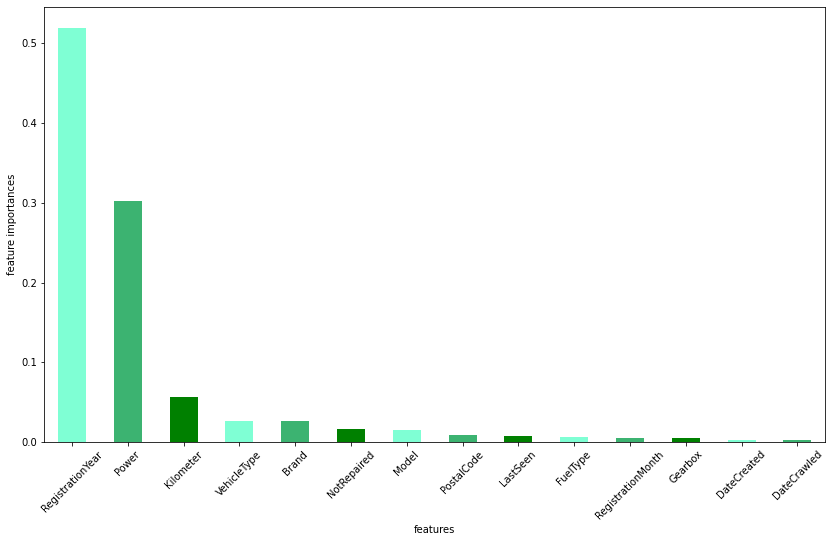

In [64]:
pd.Series(model_rfr.feature_importances_, index=features_test_wood.columns).sort_values(ascending=False).plot(
    kind='bar', rot=45, figsize=(14, 8), color=['aquamarine', 'mediumseagreen', 'green']
)
plt.xlabel('features')
plt.ylabel('feature importances');

LabelEncoder в случайном лесу показал на тестовых данных результат даже чуть лучше.

**Light Gradient Boosting:**

In [42]:
for feature in cat_cols:
    df_old[feature] = pd.Series(df_old[feature], dtype="category")

In [43]:
features_train_old, features_valid_old, features_test_old, target_train_old, target_valid_old, target_test_old = train_valid_test(df_old)
print(features_train_old.shape, features_valid_old.shape, features_test_old.shape)

(212621, 14) (70874, 14) (70874, 14)


In [44]:
%%time
model = lgb.LGBMRegressor(metric='rmse', learning_rate=0.05, num_leaves=31,
                          max_bin=255, n_estimators=256, random_state=RAND)
model.fit(features_train_old, target_train_old)

CPU times: user 34 s, sys: 200 ms, total: 34.2 s
Wall time: 34.5 s


LGBMRegressor(learning_rate=0.05, max_bin=255, metric='rmse', n_estimators=256,
              random_state=42)

In [45]:
p = model.predict(features_test_old)

In [46]:
mean_squared_error(p, target_test_old, squared=False)

1651.2816543761699

In [47]:
#r2_score
model.score(features_train_old, target_train_old)

0.8662327936500974

In [48]:
%%time
best_score = 1000000
for n_est in range(200, 300, 10):
    model = lgb.LGBMRegressor(metric='rmse', learning_rate=0.05, num_leaves=31,
                              max_bin=255, n_estimators=n_est, random_state=RAND)
    model.fit(features_train_old, target_train_old)
    p = model.predict(features_valid_old)
    mean_squared_error(p, target_valid_old, squared=False)
    if mean_squared_error(target_valid_old, model.predict(features_valid_old), squared=False) < best_score:
        best_score = mean_squared_error(target_valid_old, p, squared=False)
        best_n_est = n_est
'root_mean_squared_error: ' + str(best_score) + ';    estimators:' + str(best_n_est)

CPU times: user 8min 51s, sys: 2.52 s, total: 8min 54s
Wall time: 8min 58s


'root_mean_squared_error: 1728.590952549168;    estimators:290'

In [49]:
%%time
best_score = 1000000
for l in range(25, 31, 1):
    model = lgb.LGBMRegressor(metric='rmse', learning_rate=0.05, num_leaves=l,
                              max_bin=255, n_estimators=290, random_state=RAND)
    model.fit(features_train_old, target_train_old)
    p = model.predict(features_valid_old)
    mean_squared_error(p, target_valid_old, squared=False)
    if mean_squared_error(target_valid_old, model.predict(features_valid_old), squared=False) < best_score:
        best_score = mean_squared_error(target_valid_old, p, squared=False)
        best_l = l
'root_mean_squared_error: ' + str(best_score) + ';    num_leaves:' + str(best_l)

CPU times: user 9min, sys: 2.96 s, total: 9min 3s
Wall time: 9min 9s


'root_mean_squared_error: 1730.9617756113928;    num_leaves:30'

Test:

In [52]:
%%time
model_lgb = lgb.LGBMRegressor(metric='rmse', learning_rate=0.05, num_leaves=30,
                              max_bin=255, n_estimators=290, random_state=RAND)
model_lgb.fit(features_train_old, target_train_old)
p_test = model_lgb.predict(features_test_old)
mean_squared_error(target_test_old, p_test, squared=False)

CPU times: user 1min 33s, sys: 447 ms, total: 1min 33s
Wall time: 1min 34s


1744.3474386924745

## Анализ моделей

Лучший скор среди моделей бэггинга и линейной регрессии: 1947 (rmse) у случайного леса, однако дерево решений отработало в 6 раз быстрее без значительных потерь метрики. Интересно также, что модель с LabelEncoder отработала на деревьях в 6 раз быстрее, что с OneHotEnocoder-ом (6с и 36с соответственно на случайном лесу).  
Если смотреть среди всех моделей, то градиентный бустинг показал лучший результат метрики: 1730 (rmse)

## Вывод

Построили модель для определения стоимости автомобиля в зависимости от признаков.  
Были протестированы модели линейной регрессии, дерево решений, случайный лес и бустинг. Выяснили, что лучшее качество дает модель градиентного бустинга (LightGBM), однако сильно более затратно по времени (в 10 раз дольше, чем модель дерева решений).  
Лучшая модель в сочетании скорости работы и скора: RandomForest с кодировкой признаков LabelEncoder. Самые важные признаки для модели: год регистрации автомобиля, мощность и пробег.